# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 1

        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        
        trees = [DecisionTreeRegressor(max_depth=self.max_depth) for i in 
                 range(self.n_estimators)]
        predictions = []
        y_new = y
        for i in range(self.n_estimators):
            self.tree = trees[i]
            trees[i] = self._fit_predict_tree(x, y_new)[0]
            predictions.append(self._fit_predict_tree(x, y_new)[1])
            y_new = y - sum(predictions)
        self.trees = trees
        return self

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = self.tree
        tree.fit(x, y)
        return tree, self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here

        y_pred = np.sum([self.gamma * self.learning_rate * tree.predict(x) for tree in self.trees], axis=0)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
np.random.seed(19052019)

X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train, y_train, \
                                                                              test_size=0.3, random_state=42)

# GridSearch работал долго, поэтому сделала так:
min_mse = None
best_params = {'n_estimators': None, 'max_depth': None, 'learning_rate': None}
import itertools
for n_est, depth, lr in itertools.product([350], [3, 4, 5], [0.08, 0.06, 0.05, 0.04]): 
    gb = GradientBoosting(n_estimators=n_est, max_depth=depth, learning_rate=lr)
    gb.fit(X_train_train, y_train_train)
    cur_mse = mean_squared_error(y_train_valid, gb.predict(X_train_valid))
    if min_mse is None or min_mse > cur_mse:
        min_mse = cur_mse
        best_params['n_estimators'] = n_est
        best_params['max_depth'] = depth
        best_params['learning_rate'] = lr

print(f'Min train-valid MSE: {min_mse}\n'
  f'Best params: {best_params}')

Min train-valid MSE: 8.177954302725174
Best params: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.05}


In [7]:
np.random.seed(19052019)
gb = GradientBoosting(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], \
                      learning_rate=best_params['learning_rate'])
gb.fit(X_train, y_train)
print(mean_squared_error(y_test, gb.predict(X_test)))

11.736853320543311


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [8]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [9]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [10]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train_ref = train[['Distance', 'DepTime']].values
y_train_ref = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test_ref = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_ref, y_train_ref, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.6977000970898886

In [11]:
x_train = train.iloc[:,:-1]
cat_mask = (x_train.dtypes == 'object').values
X_train = pd.get_dummies(x_train, columns=x_train.columns[cat_mask], drop_first=True)
X_test = pd.get_dummies(test, columns=test.columns[cat_mask], drop_first=True)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [12]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(silent=True)
params = {
    'depth':range(2, 7, 2),
    'min_data_in_leaf':range(1,7,2)
}

GS = GridSearchCV(estimator=model, 
                        param_grid=params,
                        scoring='roc_auc',
                        cv=5)

GS.fit(X_valid, y_valid)
GS.best_params_

{'depth': 6, 'min_data_in_leaf': 1}

In [14]:
model = CatBoostClassifier(depth=GS.best_params_['depth'], min_data_in_leaf= GS.best_params_['min_data_in_leaf'], silent=True)
model.fit(X_train_part, y_train_part)
y_pred = model.predict(X_valid)

roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7417489900421119

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [15]:
from scipy.spatial import distance

In [16]:
class dbscan:
    def __init__(self, eps, min_samples):
        self._eps = eps
        self._min_samples = min_samples
        
    def fit_predict(self, X):
        X = np.asarray(X)
        n = X.shape[0]
        # создаем список, в котором будут храниться cluster_id каждого объекта
        # сначала все объекты Unclassified
        clusters = ['Unclassified']*n
        cluster_id = 1

        for i in range(0, n):
            point = X[i]
            if clusters[i] == 'Unclassified':
                neighbours = self.range_query(i, X)
                if self.grow_cluster(i, neighbours, clusters, cluster_id, X):
                      cluster_id = cluster_id + 1
        return clusters



    def grow_cluster(self, root, neighbours, clusters, cluster_id, X): 
      # root - индекс точки, от которой планируем растить кластер
        if len(neighbours) < self._min_samples:
            clusters[root] = -1 # -1 - соответствует кластеру noise
            return False
        # если у точки root достаточно соседей на расстоянии, меньшем, чем эпсилон
        # размечаем их кластеры соответствующими cluster_id
        clusters[root] = cluster_id
        for neighbour in neighbours:
            clusters[neighbour] = cluster_id
        # ищем подходящих соседей соседей и добавляем их в кластер    
        while len(neighbours) > 0:
            current_neighbour = neighbours[0]
            new_neighbours = self.range_query(current_neighbour, X)
            if len(new_neighbours) >= self._min_samples:
                for i in range(0, len(new_neighbours)):
                    new_neighbour = new_neighbours[i]
                    if clusters[new_neighbour] == 'Unclassified' or clusters[new_neighbour] == -1:
                        neighbours.append(new_neighbour)
                        clusters[new_neighbour] = cluster_id
            neighbours = neighbours[1:]
        return True


    def range_query(self, x, X): 
        """Возвращает точки на расстоянии <= eps от x"""
        # x - индекс точки, от которой считаем расстояния 
        neighbours = []
        n = X.shape[0]
        for i in range(n):
            if self.dist(X[i], X[x]) <= self._eps:
                neighbours.append(i)
        return neighbours

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return distance.euclidean(a, b)

        

Проверим себя на простом примере:

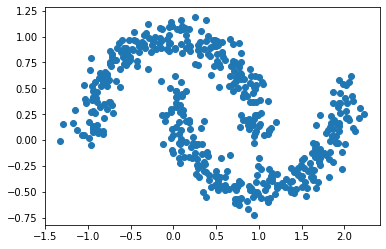

In [17]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, _ = make_moons(n_samples=500, noise=0.1, random_state=55)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

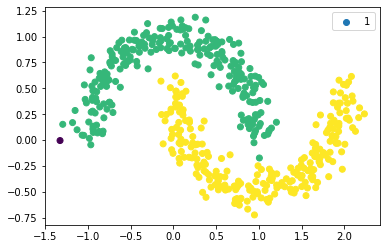

In [32]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

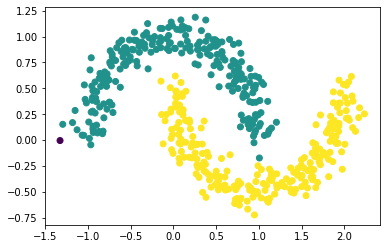

In [19]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



Или хотя бы что-нибудь такое: 

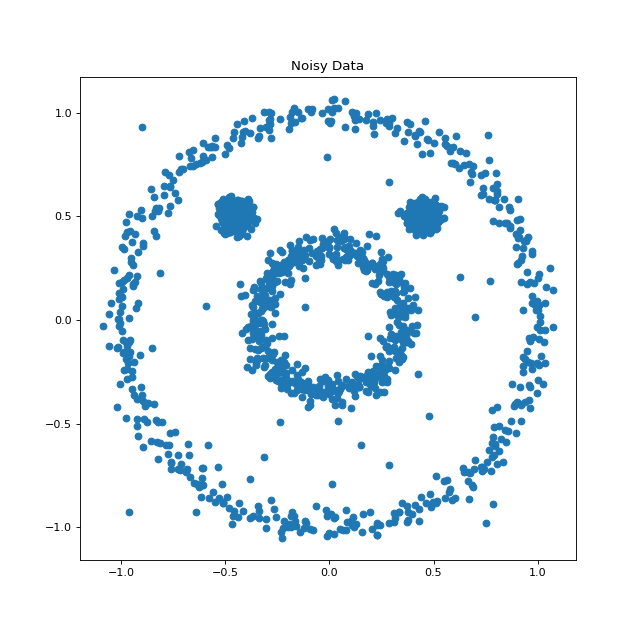

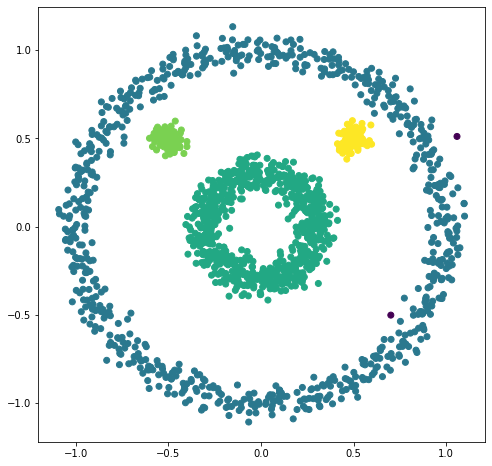

In [20]:
from sklearn.datasets import make_circles
head = make_circles(1500, factor=0.3, noise=0.05, random_state=55)[0]
eye1 = np.random.normal(scale=0.04, loc=(-0.5, 0.5), size=(100, 2))
eye2 = np.random.normal(scale=0.04, loc=(0.5, 0.5), size=(100, 2))
data = np.concatenate((head, eye1, eye2), axis=0)

clusters = dbscan(eps=0.1, min_samples=10).fit_predict(data)

plt.figure(figsize=(8, 8))
plt.scatter(data[:,0], data[:,1], c=clusters);


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [21]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 8.95 ms, sys: 0 ns, total: 8.95 ms
Wall time: 8.9 ms


In [22]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 2.82 s, sys: 7.79 ms, total: 2.83 s
Wall time: 2.85 s


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

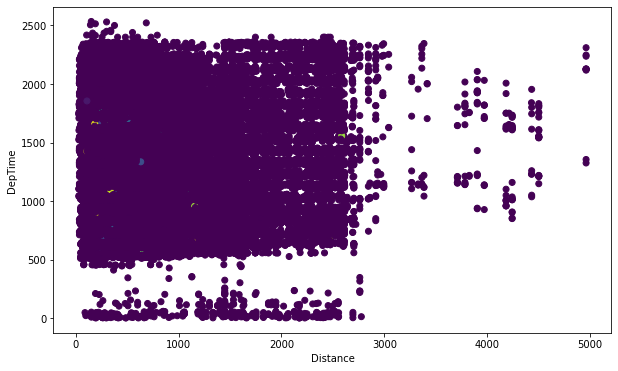

In [35]:
clustering = DBSCAN().fit_predict(X_train_ref)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_ref[:,0], X_train_ref[:,1], c=clustering)
plt.xlabel('Distance')
plt.ylabel('DepTime')
plt.show()

In [36]:
print(len(set(clustering)))
# количество кластеров. однако мы видим только шум. это связано с дефолтными параметрами. там очень маенький eps и min_samples

127


Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ При небольшом eps получается очень много шумовых точек, что связано с масштабом признаков. И Distance, и DepTime изменяются в достаточно больших дипазонах от 0 до 5000, и от 0 до 2500 соответственно. Настолько похожих (с очень маленьким eps) объектов в выборке не наблюдается, из-за чего большая часть точек обозначается шумом. Минимальное количество соседей влияет на добавление в кластеры достаточно разреженных точек. С помощью этого параметра можно регулировать необходимую плотность наших кластеров.


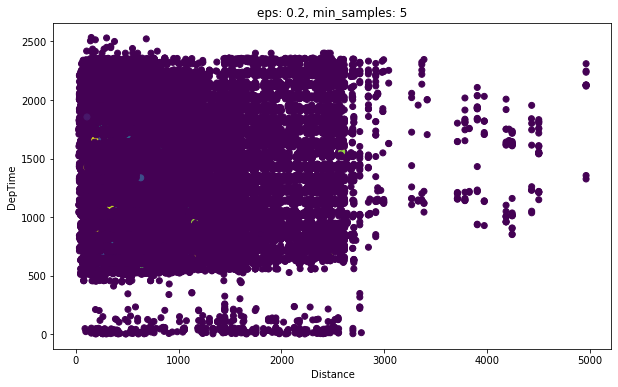

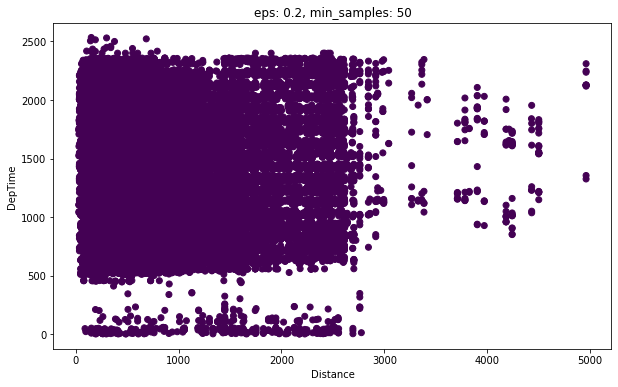

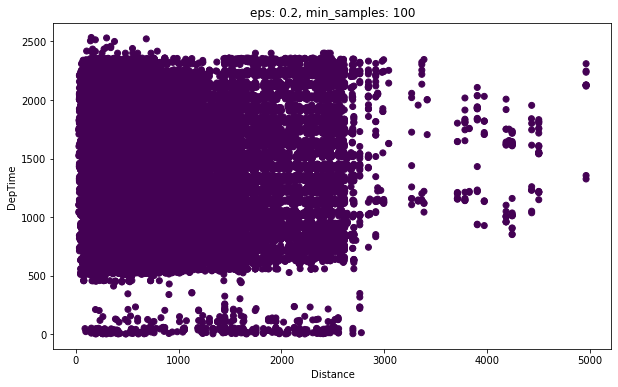

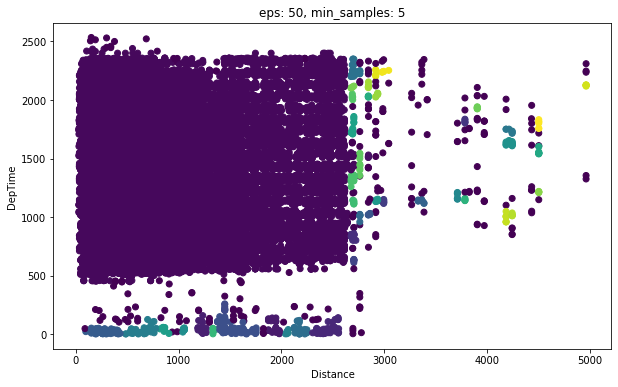

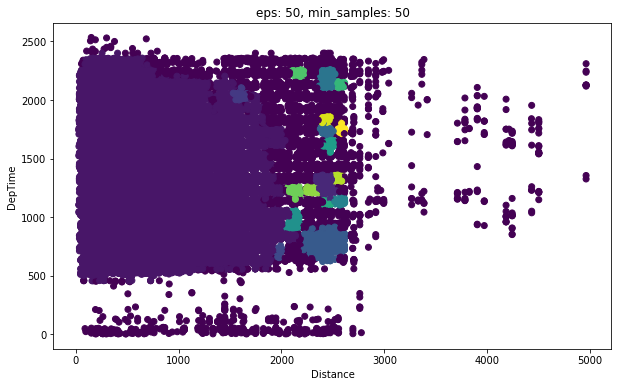

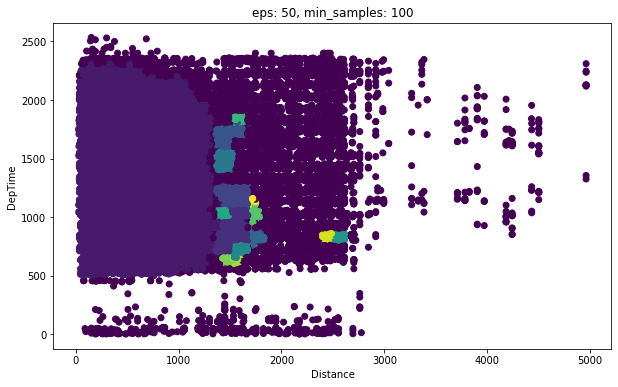

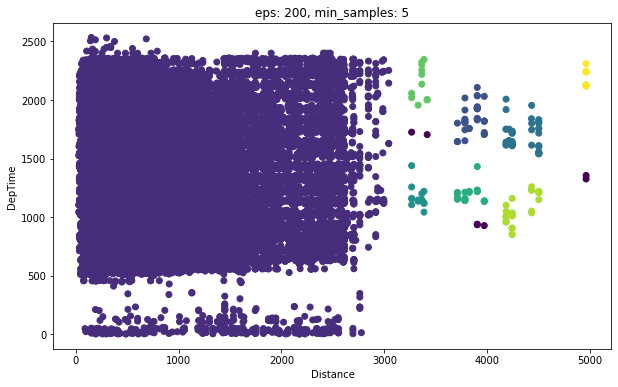

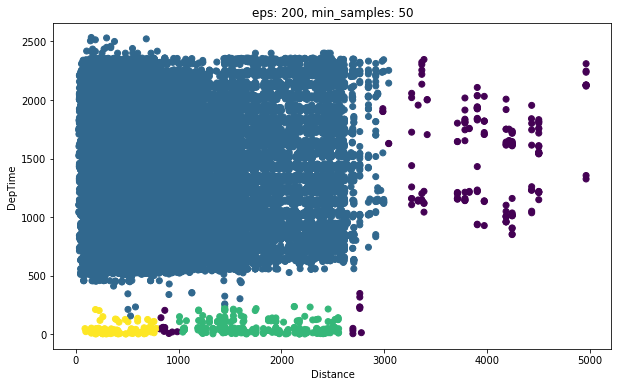

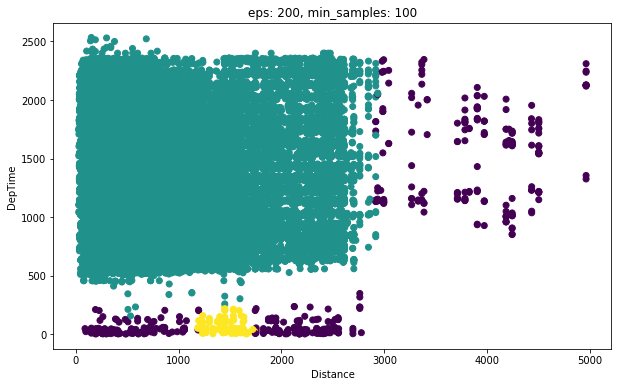

In [24]:
import itertools
eps_list = [0.2, 50, 200]
min_samples = [5, 50, 100]


for eps, min_samples in list(itertools.product(eps_list, min_samples)):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_train_ref)
    plt.figure(figsize=(10, 6))
    plt.title(f'eps: {eps}, min_samples: {min_samples}')
    plt.scatter(X_train_ref[:,0], X_train_ref[:,1], c=clustering)
    plt.xlabel('Distance')
    plt.ylabel('DepTime')
    plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [27]:
new_train = train.copy()[['Distance', 'DepTime']]
clusters = DBSCAN(eps=200, min_samples=50).fit(X_train_ref).labels_
new_train['cluster'] = clusters

X_train_part, X_valid, y_train_part, y_valid = train_test_split(new_train.values, y_train, test_size=0.3)
model_with_clusters = CatBoostClassifier(depth=GS.best_params_['depth'], min_data_in_leaf= GS.best_params_['min_data_in_leaf'], silent=True, cat_features=[2])
model_with_clusters.fit(X_train_part, y_train_part)
y_pred = model_with_clusters.predict(X_valid)

roc_auc_score(y_valid, model_with_clusters.predict_proba(X_valid)[:, 1])

0.7053924142047437

__Ответ:__

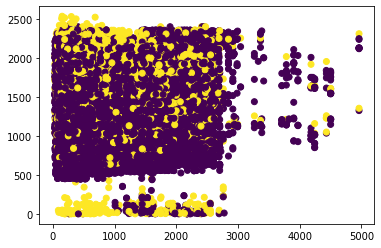

In [31]:
 plt.scatter(X_train_ref[:,0], X_train_ref[:,1], c=y_train_ref);
 # Качество не улучшилось, поскольку видим, что целевая переменная перемешана внутри кластеров
 # Качество сравнивала с референсом XGboost (улучшение незначительно)